# CNN redes convolucionales Jorge Cueva

Durante esta práctica se busca utilizar el dataset de imagenes food101 de tensorflow datasets, para entrenar una red convolucional.
Objetivos:
- Realizar una introducción al dataset
- Realizar un un analisis exploratorio
- Desarrollar, entrenar y optimizar una red convolucional.
- Predecir nuevas imagenes.






El documento ahora, está compuesto en partes, cada una correspondiente a una de las órdenes de la práctica. seguido de la siguiente forma

## Índice

1. [Descripción del problema y dataset](#1-descripción-del-problema-y-dataset)  
2. [Análisis exploratorio](#2-análisis-exploratorio)  
3. [Red neuronal](#3-red-neuronal)  
   - [3.1 Desarrollo](#31-desarrollo)  
   - [3.2 Entrenamiento](#32-entrenamiento)  
   - [3.3 Optimización de la red](#33-optimización-de-la-red)  
4. [Evaluación con el conjunto de test](#4-evaluación-con-el-conjunto-de-test)  
5. [Predicciones](#5-predicciones)  
6. [Conclusiones](#6-conclusiones)  
7. [Referencias](#7-referencias)  

## 1. Descripción del problema y dataset

El dataset food101 está conformado por 101 categorías y 101000 imágenes. 

Para cada clase existen 1000 imagenes conformadas en 250 para pruebas y 750 para entrenamiento.

Todas las imágenes tienen un tamaño de 512 pixeles de ancho.

El link de información principal del dataset es el siguiente [Link del dataset](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/)

Aunque no usaremos los tamaños indicados por el propio dataset, sino que lo haremos nosotros mismos.

### 1.1 Carga del dataset.

In [1]:
#No tiene que ver con el entrenamiento, pero me permite saber si la la GPU funciona para entrenar el modelo.
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))
print("Dispositivo activo:", tf.test.gpu_device_name())

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Dispositivo activo: /device:GPU:0


In [3]:
import tensorflow as tf
import pandas as pd
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

import cv2
import os
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense,  BatchNormalization
from keras.models import load_model
from keras.models import save_model
import numpy as np
from PIL import Image 


In [9]:
#Carga del dataset
# Usar el dataset descargado localmente especificando el parámetro data_dir
data = tfds.load('food101', split='train+validation', as_supervised=True, data_dir="food-101/")

Tomamos todos los elemenos del dataset como si fuera un solo conjunto, para poder manejarlo a nuestro gusto.

## 2. Análisis exploratorio

### 2.1 Información de los datos

El dataset cuenta con 101 clases de comida. 
El conjunto de datos, contiene 2 carpetas importantes, images, que contiene en subcarpetas todas imagenes de cada categoría, y meta, que contiene información para la configuración del dataset. clases y labels que son lo mismo con una sintaxis distinta, y el conjunto de test y train que indican cuales con los datos de entrenamiento y los de evaluación conforme la disposición del dataset 25% para pruebas y 75% para entrenamiento.

Tambien podemos ver las dimesiones de las imagenes, ya que todas tienen 512 de ancho, pero el alto varía.

### 2.2 Visualización de datos

tfds.showExamples(), se encuentra en la documentación de tensorflow para visualización de datos aunque esto no nos permite saber informacion util.

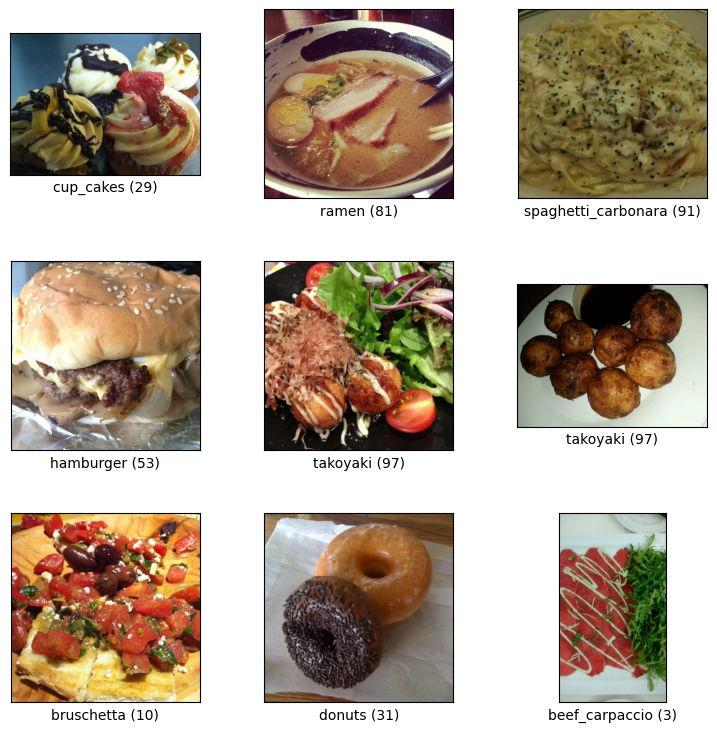

In [4]:
#Cargandolo y utilizando show_examples

builder = tfds.builder("food101", data_dir="food-101/")
builder.download_and_prepare()

ds_validation = builder.as_dataset(split="validation", as_supervised=True)
info_validation = builder.info
tfds.show_examples(ds_validation,info_validation)
print()

In [5]:

totalEntrenamiento = int(16836)  #valor de total/6

#Para seguir la logica de cross validation, entrenar durante 6 epocas. y que el conjunto cambie en cada epoca
# voy a hacer 6 conjuntos en cada entrenamiento el dataset es de 6 bloques, en donde, uno de los bloques se intercambia para que el modelo se sobreentrene con las mismas imagenes.
# 
# 


data = data.shuffle(10000, seed=42)  # Mezclamos por reproducibilidad

# Total de ejemplos y tamaño del pliegue
total = 101000  # total de imágenes en train+validation
k = 6
fold_size = int(total // k)

# Función para obtener conjunto de entrenamiento y prueba para un pliegue dado
def get_fold(data, fold_idx, fold_size):
    test_start = fold_idx * fold_size
    test_end = test_start + fold_size
    test = data.skip(test_start).take(fold_size)
    train = data.take(test_start).concatenate(data.skip(test_end))
    
    return train, test

# Crear todos los conjuntos
folds = []
for i in range(k):
    train, test = get_fold(data, i, fold_size)
    folds.append((train, test))

Aunque no es necesario hacerlo ahora, divido el dataset en dos conjuntos, siendo que uno me servirá para entrenamiento y otro para validaciónes, si bien podría utilizar más valorse para entrenamiento, quiero que este no sea tan pesado para procesarlo, entonces n lugar de usar las 80000 imagenes para entrenar, uso 70000 que si bien no es mucho menos, es una reducción significativa.

#### Cantidad de datos
Dado que estamos trabajando con otros datos a los que recomienda el dataset. veremos que la cantidad de datos por clase sea proporcional

In [6]:
def contarCategorias(dataset):
    categorias = {}
    for _, label in dataset:
        if label.numpy() in categorias:
            categorias[label.numpy()] += 1
        else:
            categorias[label.numpy()] = 1
    return categorias


In [ ]:
#Total de datos entrenados
frecuencias = contarCategorias(data)
print("Total: "+ str(frecuencias))

Total: {56: 1000, 76: 1000, 21: 1000, 64: 1000, 10: 1000, 70: 1000, 90: 1000, 100: 1000, 53: 1000, 73: 1000, 33: 1000, 37: 1000, 19: 1000, 4: 1000, 77: 1000, 11: 1000, 96: 1000, 18: 1000, 59: 1000, 80: 1000, 22: 1000, 43: 1000, 2: 1000, 92: 1000, 8: 1000, 48: 1000, 23: 1000, 84: 1000, 44: 1000, 34: 1000, 61: 1000, 67: 1000, 30: 1000, 79: 1000, 46: 1000, 89: 1000, 24: 1000, 29: 1000, 9: 1000, 41: 1000, 3: 1000, 57: 1000, 69: 1000, 0: 1000, 87: 1000, 12: 1000, 49: 1000, 42: 1000, 85: 1000, 58: 1000, 83: 1000, 14: 1000, 52: 1000, 28: 1000, 74: 1000, 5: 1000, 17: 1000, 97: 1000, 45: 1000, 82: 1000, 91: 1000, 13: 1000, 7: 1000, 26: 1000, 27: 1000, 36: 1000, 72: 1000, 68: 1000, 99: 1000, 55: 1000, 40: 1000, 65: 1000, 25: 1000, 47: 1000, 93: 1000, 1: 1000, 63: 1000, 16: 1000, 38: 1000, 39: 1000, 15: 1000, 78: 1000, 6: 1000, 88: 1000, 50: 1000, 98: 1000, 31: 1000, 81: 1000, 66: 1000, 51: 1000, 54: 1000, 75: 1000, 94: 1000, 32: 1000, 86: 1000, 95: 1000, 20: 1000, 35: 1000, 71: 1000, 60: 1000, 6

In [ ]:
#Podriamos contar cuantos de valores de cada grupo se toman en cada epoca.
train_1,test_1 = folds[0]

print(str(contarCategorias(test_1)))

{99: 151, 5: 166, 21: 178, 81: 159, 53: 174, 72: 173, 57: 160, 40: 179, 27: 186, 100: 162, 32: 157, 28: 174, 34: 171, 67: 169, 42: 156, 77: 160, 19: 172, 92: 177, 61: 177, 46: 174, 71: 150, 22: 182, 97: 172, 73: 176, 31: 165, 91: 169, 52: 167, 9: 175, 86: 168, 17: 180, 98: 150, 88: 173, 38: 157, 12: 149, 60: 168, 14: 181, 79: 147, 29: 157, 93: 166, 20: 171, 3: 167, 6: 155, 58: 166, 48: 156, 82: 178, 89: 143, 85: 178, 2: 177, 65: 169, 56: 175, 66: 153, 51: 172, 23: 177, 54: 189, 26: 172, 45: 141, 8: 152, 39: 170, 80: 175, 10: 177, 33: 154, 0: 167, 49: 157, 15: 161, 75: 154, 37: 152, 83: 149, 74: 172, 69: 167, 90: 161, 50: 177, 70: 170, 95: 149, 78: 170, 4: 162, 59: 178, 47: 173, 84: 177, 24: 151, 25: 142, 55: 166, 94: 175, 43: 156, 44: 176, 16: 152, 13: 184, 63: 171, 68: 163, 7: 178, 30: 167, 64: 178, 36: 153, 62: 170, 11: 168, 18: 182, 76: 158, 96: 168, 87: 168, 1: 163, 41: 192, 35: 162}


(0) lasagna (512, 512, 3)


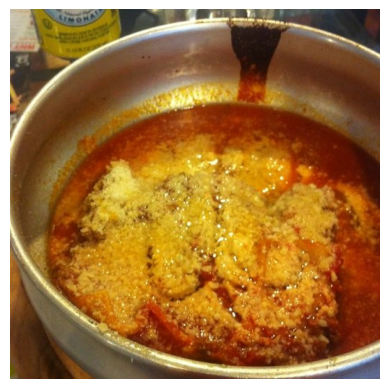

In [11]:
for i, (image, label) in enumerate(test_1.take(1)):
    print(f"({i}) {builder.info.features['label'].int2str(label)} {image.shape}") #Imprimo su posicion, label, y dimensiones
    plt.imshow(image)
    
    plt.axis("off")
    plt.show()
    print()


## 3. Red Neuronal

Una vez que tenemos el dataset podemos empezar con el desarrollo de la red. utilizaremos para ello:


### 3.0.1 Preparación del dataset.

Dado que las imagenes del dataset se encuentran en dimensiones distintas, lo primero va a ser tener que rehacerlas en un tamaño fijo. 
y cómo se va a tener que hacer con todas, definimos funcion y la comprobamos

In [6]:
#Metodo que me sirve para redimensionar las imagenes, y que todas tengan un mismo tamaño, y que sean más pequeñas para acelerar el entrenamiento.

def resize (image,label ,size=128): #El size predeterminado es de 128, se puede cambiar antes de entrenar,
    image = tf.image.resize(image, (size, size))         # Redimensio
    image = tf.cast(image, tf.float32) / 255.0    #Normalización
    return image, label

#Obtengo los labels, los coloco en una lista, y cambio el formato para que no tengan el salto de linea.
labelss = open("food-101/meta/labels.txt")
labels = labelss.readlines()

for i in range(len(labels)):
    labels[i] = labels[i].replace('\n', '')

#metodo que retorna el valor del label dado su nnumero
def getLabels(valor: int):
    return labels[valor]

Podemos ver ejemplos de cómo se ve una imagen antes y despues de transoformarla

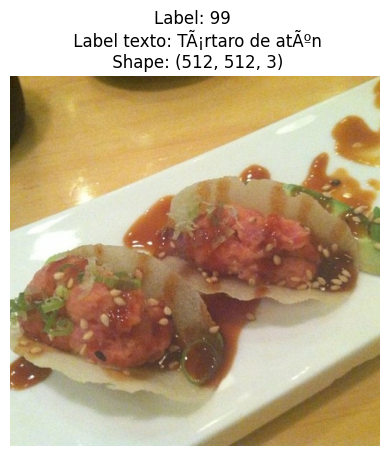

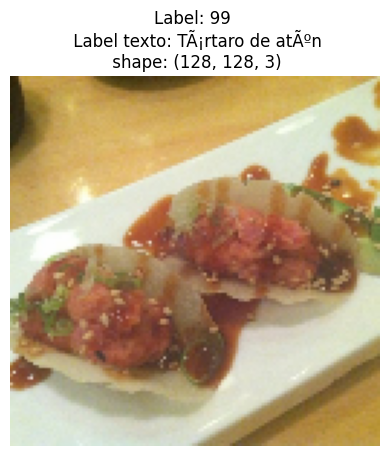

In [9]:
for image,label in train_1.take(1):
    plt.imshow(image)
    plt.title(f'Label: {label.numpy()} \n Label texto: {getLabels(int(label))}\n Shape: {image.shape}')
    plt.axis('off')
    plt.show()
    image, label = resize(image, label)
    plt.imshow(image)
    plt.title(f'Label: {label.numpy()} \n Label texto: {getLabels(int(label))}\n shape: {image.shape}')
    plt.axis('off')
    plt.show()




###     3.1 Desarrollo

In [10]:
imagenshape = None
labelshape = None
for image, label in train_1.take(1):
    image, label = resize(image, label)
    imagenshape = image
    labelshape = label
print(imagenshape.shape, labelshape.shape)

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=imagenshape.shape),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.3),

    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(len(labels), activation='softmax')
])
#compilamos el modelo
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

(128, 128, 3) ()


In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                        

### 3.2 Entrenamiento

In [17]:
size_batch = 32  # utilizo el batch de 32 para que sea lo mas rapido posible, a pesar de qu a largo plazo menos eficiente.

#train, test = folds[0]  # En cada epoca este valor se cambia por la siguiente iteracion el maximo de folds es k=6 primer intento 
train, test = folds[5]

train_dataset = (
    train
    .map(resize, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(size_batch)
    .prefetch(tf.data.AUTOTUNE)
)

test_dataset = (
    test
    .map(resize, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(size_batch)
    .prefetch(tf.data.AUTOTUNE)
)

epocas = 1 # se entrena una sola epoca, y se hace asi con cada uno de los conjuntos de datos
with tf.device('/GPU:0'):   
    history = model.fit(train_dataset,validation_data=test_dataset, epochs=epocas, verbose=1)

2631/2631 [==============================] - 282s 106ms/step - loss: 2.0173 - accuracy: 0.4803 - val_loss: 1.1629 - val_accuracy: 0.6944


### 3.3 Optimización de la red

Las epocas parecen ser lo que más influye en el entrenamiento de la red. En cuanto a cambiar el tamaño de batch no altera apenas los valores de la red, pero si aumenta mucho el tiempo de entrenamiento.
![alt text for screen readers](output.png "Text to show on mouseover")

### 3.4 Guardado de la red neuronal

In [26]:
model.save("ModeloCross_val.h5")

## 4. Evaluación con el conjunto de test

In [13]:
# ds_validation = ds_validation.map(resizeImg).batch(batch_size).prefetch(tf.data.AUTOTUNE)
size_batch = 32
test_dataset = (
    data
    .map(resize, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(size_batch)
    .prefetch(tf.data.AUTOTUNE)
)

model.evaluate(test_dataset,verbose=1)

#2.772
#0.4055


3157/3157 [==============================] - 48s 15ms/step - loss: 1.0877 - accuracy: 0.8063


[1.087674617767334, 0.8062772154808044]

## 5. Predicciones

In [4]:

model = load_model("Mejor_Modelo.h5")


In [7]:
# Parámetros

model = load_model("Mejor_Modelo.h5")


labelss = open("food-101/meta/labels.txt")
labels = labelss.readlines()

for i in range(len(labels)):
    labels[i] = labels[i].replace('\n', '')

def getLabels(valor: int):
    return labels[valor]

def predecir_desde_camara(IMG_SIZE = 128):
    cap = cv2.VideoCapture(0) 

    if not cap.isOpened():
        print("No se puede acceder a la cámara")
        return
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        img = cv2.resize(frame, (IMG_SIZE, IMG_SIZE))
        img = img.astype("float32") / 255.0
        img = np.expand_dims(img, axis=0)
        pred = model.predict(img)
        pred_idx = np.argmax(pred)
        confidence = np.max(pred)
        if pred_idx < len(labels):
            pred_label = labels[pred_idx]
        else:
            pred_label = "Desconocido"
        texto = f'{pred_label} ({confidence:.2f})'
        cv2.putText(frame, texto, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (50, 255, 50), 2, cv2.LINE_AA)
        cv2.imshow("Predicción IA - Webcam", frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()


1/1 [==============================] - 6s 6s/step


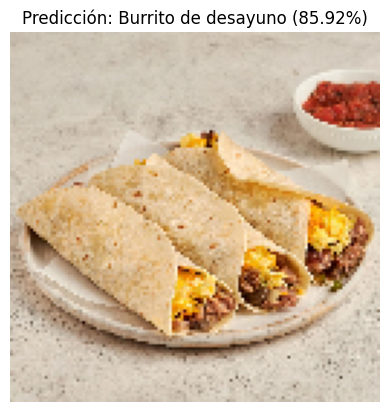

La imagen fue clasificada como: Burrito de desayuno con 85.92% de confianza


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def predict_new_image(img_path, img_size=(125, 125)):

    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img).astype("float32") / 255.0
    img_array = np.expand_dims(img_array, axis=0) 
    preds = model.predict(img_array)
    pred_class = np.argmax(preds, axis=1)[0]
    class_name = labels[pred_class]
    confidence = 100 * np.max(preds)

    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Predicción: {class_name} ({confidence:.2f}%)')
    plt.show()

    print(f'La imagen fue clasificada como: {class_name} con {confidence:.2f}% de confianza')

# Ejemplo de uso:
predict_new_image(
    "sss.jpg",
    img_size=(128, 128)
)

In [14]:
# Ejecutar
predecir_desde_camara()

1/1 [==============================] - 0s 18ms/step


In [8]:
size_batch = 128
test_dataset = (
    x_test
    .map(resize, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(size_batch)
    .prefetch(tf.data.AUTOTUNE)
)

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
# Obtener las predicciones del modelo
y_true = []
y_pred = []
# Obtener predicciones y etiquetas verdaderas
for images, labels_batch in test_dataset:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels_batch.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Tabla de aciertos y errores por categoría
resultados = []
for idx, label_name in enumerate(labels):
    total = np.sum(cm[idx])
    correctos = cm[idx, idx]
    errores = total - correctos
    resultados.append({
        "Categoría": label_name,
        "Aciertos": int(correctos),
        "Errores": int(errores),
        "Total": int(total)
    })

df_resultados = pd.DataFrame(resultados)
for result in df_resultados.itertuples():
    print(f"Categoría: {result.Categoría}, Aciertos: {result.Aciertos}, Errores: {result.Errores}, Total: {result.Total}")

Categoría: Pastel de manzana, Aciertos: 33, Errores: 266, Total: 299
Categoría: Costillas de cerdo, Aciertos: 109, Errores: 189, Total: 298
Categoría: Baklava, Aciertos: 111, Errores: 194, Total: 305
Categoría: Carpaccio de res, Aciertos: 201, Errores: 101, Total: 302
Categoría: TÃ¡rtaro de res, Aciertos: 108, Errores: 196, Total: 304
Categoría: Ensalada de remolacha, Aciertos: 97, Errores: 208, Total: 305
Categoría: BuÃ±uelos, Aciertos: 194, Errores: 119, Total: 313
Categoría: Bibimbap, Aciertos: 191, Errores: 114, Total: 305
Categoría: Pudin de pan, Aciertos: 57, Errores: 252, Total: 309
Categoría: Burrito de desayuno, Aciertos: 41, Errores: 259, Total: 300
Categoría: Bruschetta, Aciertos: 75, Errores: 232, Total: 307
Categoría: Ensalada cÃ©sar, Aciertos: 126, Errores: 182, Total: 308
Categoría: Cannoli, Aciertos: 86, Errores: 235, Total: 321
Categoría: Ensalada caprese, Aciertos: 121, Errores: 180, Total: 301
Categoría: Pastel de zanahoria, Aciertos: 119, Errores: 187, Total: 306
Ca

In [ ]:
df_resultados

,Categoría,Aciertos,Errores,Total
0,Pastel de manzana,33,266,299
1,Costillas de cerdo,109,189,298
2,Baklava,111,194,305
3,Carpaccio de res,201,101,302
4,TÃ¡rtaro de res,108,196,304
...,...,...,...,...
96,Tacos,47,261,308
97,Takoyaki,85,223,308
98,TiramisÃº,118,185,303
99,TÃ¡rtaro de atÃºn,89,226,315


## 6. Conclusiones

El modelo mejor entrenado, es el que ha pasado más epocas, o al menos el qué a logrado mejores resultados, el tamaño del batch parece no afectar de gran manera al progreso en cuanto al entrenamiento y mejora del modelo.

Se ha logrado tener un modelo que utiliza la cámara del dispositivo para poder hacer una lectura y predicción en tiempo real de qué es lo que ve la camara, y qué es lo que entiende el modelo.

Se puede optimizar cada vez más una red convolucional, pero siempre es mejor cambiar algunos valores con el objetivo de que no solo enterne con algunos, lo que nos permitiría evitar problemas de overfitting en la red.

## 7. Referencias


[1] L. Bossard, M. Guillaumin, and L. Van Gool, “Food-101 – Mining Discriminative Components with Random Forests,” in European Conference on Computer Vision (ECCV), Zurich, Switzerland, 2014. [Online]. Available: https://www.vision.ee.ethz.ch/datasets_extra/food-101/

[2] TensorFlow Datasets, “food101,” TensorFlow Datasets Catalog. [Online]. Available: https://www.tensorflow.org/datasets/catalog/food101

[3] GitHub - TensorFlow Datasets Source Code, “Food101 Dataset Definition,” [Online]. Available: https://github.com/tensorflow/datasets/blob/master/tensorflow_datasets/image/food101.py